In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
from yahoo_fin import stock_info as si
from arch import arch_model
from scipy.optimize import minimize 

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Heston model calibration by maturity

In [2]:
import QuantLib as ql
from math import pow, sqrt
import pandas as pd
import numpy as np
from scipy.optimize import root
L = pd.read_excel('/Users/elyes/Desktop/df_16_04_21.xlsx')
L.index = L['OPTION EXPIRY DATE']
L = L.drop(columns='OPTION EXPIRY DATE')

In [12]:
import datetime 
from datetime import date
L.iloc[:,1] = L.iloc[:,1]
L.iloc[:,2] = L.iloc[:,2]
L['Spread'] = abs(L.iloc[:,1] - L.iloc[:,2])
L['Mid Price'] = (L.iloc[:,1] + L.iloc[:,2])/2 
L.sort_index(inplace = True)
L = L.mask(L.Strikes > 4551).dropna()
Date_16_4_21 = pd.to_datetime(date(2021, 4, 16))
L['TTM'] =  (L.index - Date_16_4_21).days/360

In [16]:
from datetime import date as dat
from scipy.stats import norm
from scipy.optimize import brentq

def implied_volatility(price_ ,S, K, T, r):
    args = [price_,S, K, T, r]
    try:
        res = brentq(Optimisor,0.0001,1000,args,maxiter=10000)
    except :
        res = np.nan
    return res

def _price_(S, K, T, r, v):
    d1 = (np.log(S/K) + (r + 0.5 * v ** 2) * T)/(v * T**(1/2))
    d2 = d1 - v * T **(1/2)
    Option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return Option_price

def Optimisor(x,args):
    price_,S, K, T, r = args
    A = _price_(S, K, T, r, x)
    MNM = A - price_
    return MNM

S0 = 4180.50
L = L.sort_values(by='TTM')

In [17]:
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()
tdy = Date_16_4_21
calculation_date = ql.Date(tdy.day,tdy.month,tdy.year)

spot = S0
ql.Settings.instance().evaluationDate = calculation_date


risk_free_rate = 0.03/100
dividend_rate = 1.45/100
drift = risk_free_rate - dividend_rate
yield_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count))

In [18]:
IV = {}
for i in range(0,len(L)):
    IVO = implied_volatility(L['Mid Price'].iloc[i],S0,L['Strikes'].iloc[i],L['TTM'].iloc[i],drift)
    IV[i] = IVO
L['Implied Volatility'] = IV.values()
L

,IV,Bid,Ask,Strikes,Spread,Mid Price,TTM,Implied Volatility
OPTION EXPIRY DATE,,,,,,,,
2021-05-21,0.3571,924.30,931.10,3250.0,6.8,927.70,0.097222,0.355634
2021-05-21,0.1252,0.65,0.85,4550.0,0.2,0.75,0.097222,0.123671
2021-05-21,0.2036,337.40,342.30,3850.0,4.9,339.85,0.097222,0.214247
2021-05-21,0.2903,628.00,633.90,3550.0,5.9,630.95,0.097222,0.292970
2021-05-21,0.3329,824.90,831.70,3350.0,6.8,828.30,0.097222,0.333990
...,...,...,...,...,...,...,...,...
2023-12-15,0.1902,365.30,413.30,4350.0,48.0,389.30,2.702778,0.190943
2023-12-15,0.1953,415.40,463.40,4250.0,48.0,439.40,2.702778,0.195719
2023-12-15,0.2006,468.80,516.80,4150.0,48.0,492.80,2.702778,0.200646


In [12]:
strikes = []
data = []
Q = L.groupby(['TTM','Strikes']).mean()
TTMs = Q.index.get_level_values('TTM').unique()
for i in TTMs:
    data.append(np.round(Q.loc[i]['Implied Volatility'].values,2).tolist())
L = L.sort_values(by='TTM')
spreads = np.abs(1/(L.groupby(['TTM','Strikes']).mean().Spread.values))
prices = (L.groupby(['TTM','Strikes']).mean())['Mid Price'].values

In [13]:
def setup_helpersLC(engine, date, strikes, 
                  data, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for j, s in enumerate(strikes):
            t = (date - ref_date )
            p = ql.Period(t, ql.Days)
            vols = data[j]
            helper = ql.HestonModelHelper(
                p, calendar, spot, s, 
                ql.QuoteHandle(ql.SimpleQuote(vols)),
                yield_ts, dividend_ts,ql.BlackCalibrationHelper.ImpliedVolError)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def setup_helpers(engine, expiration_dates, strikes, 
                  data, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for i, date in enumerate(expiration_dates):
        for j, s in enumerate(strikes):
            t = (date - ref_date )
            print(t)
            p = ql.Period(t, ql.Days)
            vols = data[i][j]
            helper = ql.HestonModelHelper(
                p, calendar, spot, s, 
                ql.QuoteHandle(ql.SimpleQuote(vols)),
                yield_ts, dividend_ts,ql.BlackCalibrationHelper.ImpliedVolError)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def cost_function_generator1(model, helpers,norm=False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] - params[2]**2
        if pen_c < 1e-50 :
            pen = 1e50
        #err =np.sum(spreads*(np.array([(opt.modelValue() - opt.marketValue())**2  for i, opt in enumerate(helpers)])))/np.sum(spreads)#[h.calibrationError() for h in helpers]r h in helpers]
        err =  pen * np.sum(spreads*np.abs([h.calibrationError() for h in helpers])**2)/np.sum(spreads)
        if norm:
            return pen *err #pen * np.sum(spreads *np.abs([h.calibrationError() for h in heston_helpers4])**2/np.array(data).reshape(1,195)[0])/np.sum(spreads)
        else:
            return error
    return cost_function


def cost_function_generator2(model, helpers,norm=False,Mono = False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] - params[2]**2
        err = np.sum(spreads * np.abs([h.calibrationError() for h in helpers]))**2  * 1/np.sum(spreads)
        if Mono == False :
            if pen_c < 1e-50 or params[0] < 0 or params[1]<0 or params[2]<0 or params[4]<0 or params[3] <= - 1 :
                pen = 1e50
        else :
            if pen_c < 1e-50 or params[0] < 0 or params[1]<0 or params[2]<0 or params[4]<0 or params[3] != - 1 :
                pen = 1e50
        if norm:
            return pen * err#len(heston_helpers4)
        else:
            return error
    return cost_function

def calibration_report(helpers, grid_data, detailed=False):
    IVMSE = np.sum(spreads*np.array([abs(h.calibrationError())**2 for h in helpers]))/np.sum(spreads)
    if detailed: print("-"*100)
    summary = "IVMSE  : %1.9f" % (IVMSE)
    print(summary)
    return IVMSE
    
def setup_model(_yield_ts, _dividend_ts, _spot, 
                init_condition=(0.02,0.2,0.5,0.1,0.01)):
    theta, kappa, sigma, rho, v0 = init_condition
    process = ql.HestonProcess(_yield_ts, _dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(_spot)), 
                           v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model) 
    return model, engine
summary= []

In [14]:
from scipy.optimize import differential_evolution
#Feller-Condition
from scipy.optimize import NonlinearConstraint
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize
from scipy.optimize import least_squares
def Cst(x):
    theta, kappa, sigma, rho, v0 = x
    A = 2*kappa*theta - sigma**2 
    return A
const = {'type': 'ineq', 'fun': Cst}

In [15]:
theta_, kappa_, sigma_, rho_, v0_ = {},{},{},{},{}
strikes = L.Strikes.sort_values().unique().tolist()
date__ = L.TTM.sort_values().unique()
for j,i in enumerate(L.index.sort_values().unique()):
    date = ql.Date(i.day,i.month,i.year)
    t = date__[j]
    data = Q.loc[t]['Implied Volatility'].tolist()
    spreads = 1/Q.loc[t]['Spread']
    model4, engine4 = setup_model(yield_ts, dividend_ts, spot)
    heston_helpers4, grid_data4 = setup_helpersLC(engine4, date, strikes, data,calculation_date, spot, yield_ts, dividend_ts)
    initial_condition = (0.02, 0.2, 0.5, 0.1, 0.01)
    bounds = [(1e-5,10),(1e-5,100), (1e-5,10), (-1,1), (1e-5,10)]
    bnds = ((1e-5,10),(1e-5,100), (1e-5,10), (-1,1), (1e-5,10))
    cost_function = cost_function_generator1(
    model4, heston_helpers4, norm=True)
    cost_function2 = cost_function_generator2(
    model4, heston_helpers4, norm=True)
    sol = differential_evolution(cost_function, bounds=bounds,tol =1e-9,maxiter = 100,popsize = 100,seed = 0)
    params_ = ql.Array(list(sol.x))
    model4.setParams(params_)
    sol = minimize(cost_function2,sol.x,tol =1e-9,method = 'Nelder-Mead')
    params_ = ql.Array(list(sol.x))
    model4.setParams(params_)
    theta_[i], kappa_[i], sigma_[i], rho_[i], v0_[i] = model4.params()
    error = calibration_report(heston_helpers4, grid_data4)    
    summary.append(["Scipy DE1", error] + list(model4.params()))  
    
    

IVMSE  : 0.000437654
IVMSE  : 0.000411060
IVMSE  : 0.000389291
IVMSE  : 0.000271185
IVMSE  : 0.000199277
IVMSE  : 0.000171848
IVMSE  : 0.000171404
IVMSE  : 0.000149166
IVMSE  : 0.000201109
IVMSE  : 0.000159302
IVMSE  : 0.000140922
IVMSE  : 0.000134256
IVMSE  : 0.000093163
IVMSE  : 0.000045897
IVMSE  : 0.000011932


In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,ConstantKernel as C

def G_Interpolator(X,Y,x1):
    x = X.reshape(-1, 1)
    y = Y.reshape(-1, 1)
    # Input space
    kernel = C(1.0, (1e-3, 1e3)) * RBF([1], (1e-2, 1e2)) + WhiteKernel(noise_level = 1)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=30)
    gp.fit(x, y)
    y_pred, MSE = gp.predict(x1.reshape(-1,1), return_std=True)
    return y_pred

In [17]:
from scipy import interpolate
from scipy.interpolate import interp1d
import datetime 
from datetime import date,timedelta

A = pd.DataFrame([theta_.values(), kappa_.values(), sigma_.values(), rho_.values(), v0_.values()]\
                  ,columns = rho_.keys(),index = ['Theta','Kappa','Sigma','Rho','V0'])
x = L.TTM.unique()
x1 = np.linspace(x.min(),x.max(),300)
df_0 = pd.DataFrame()
for i in A.index :
    X,Y = x,A.loc[i].values
    if i == 'Rho':
        df_0[i] = np.maximum(G_Interpolator(X,Y,x1).reshape(1,-1)[0],-1)
    else:
        df_0[i] = G_Interpolator(X,Y,x1).reshape(1,-1)[0]
    
df_0.index = np.array([date(2021, 4, 20) + timedelta(days = np.int(np.round(i * 360,2))) for i in x1])

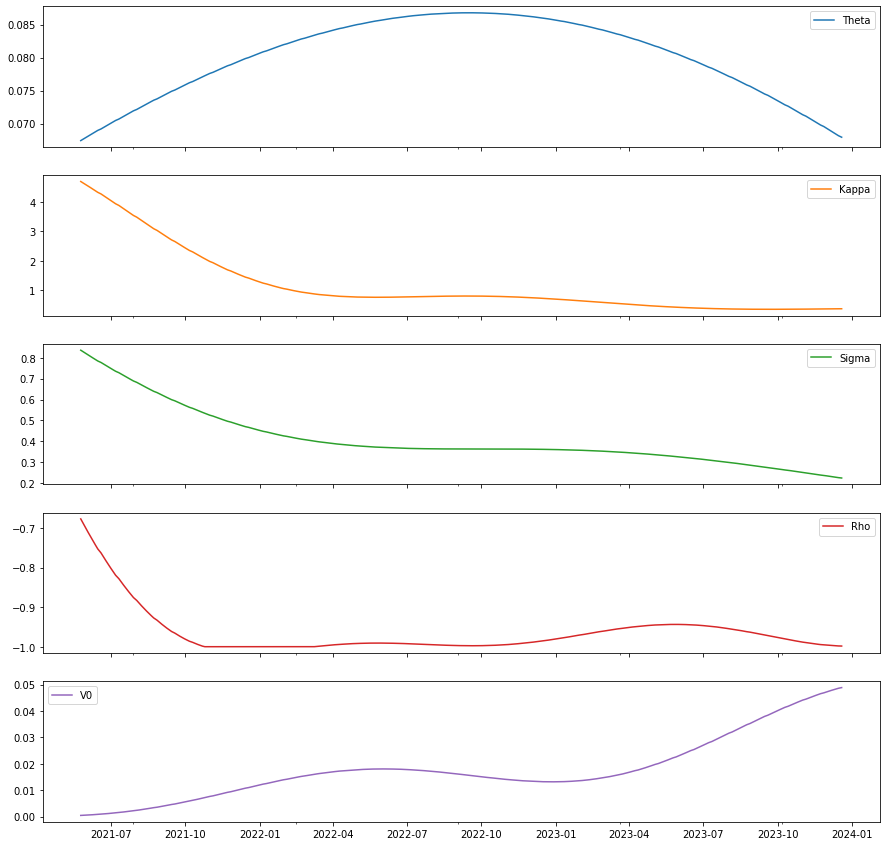

In [18]:
df_0.plot(subplots=True,figsize=(15,15))
plt.show()

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


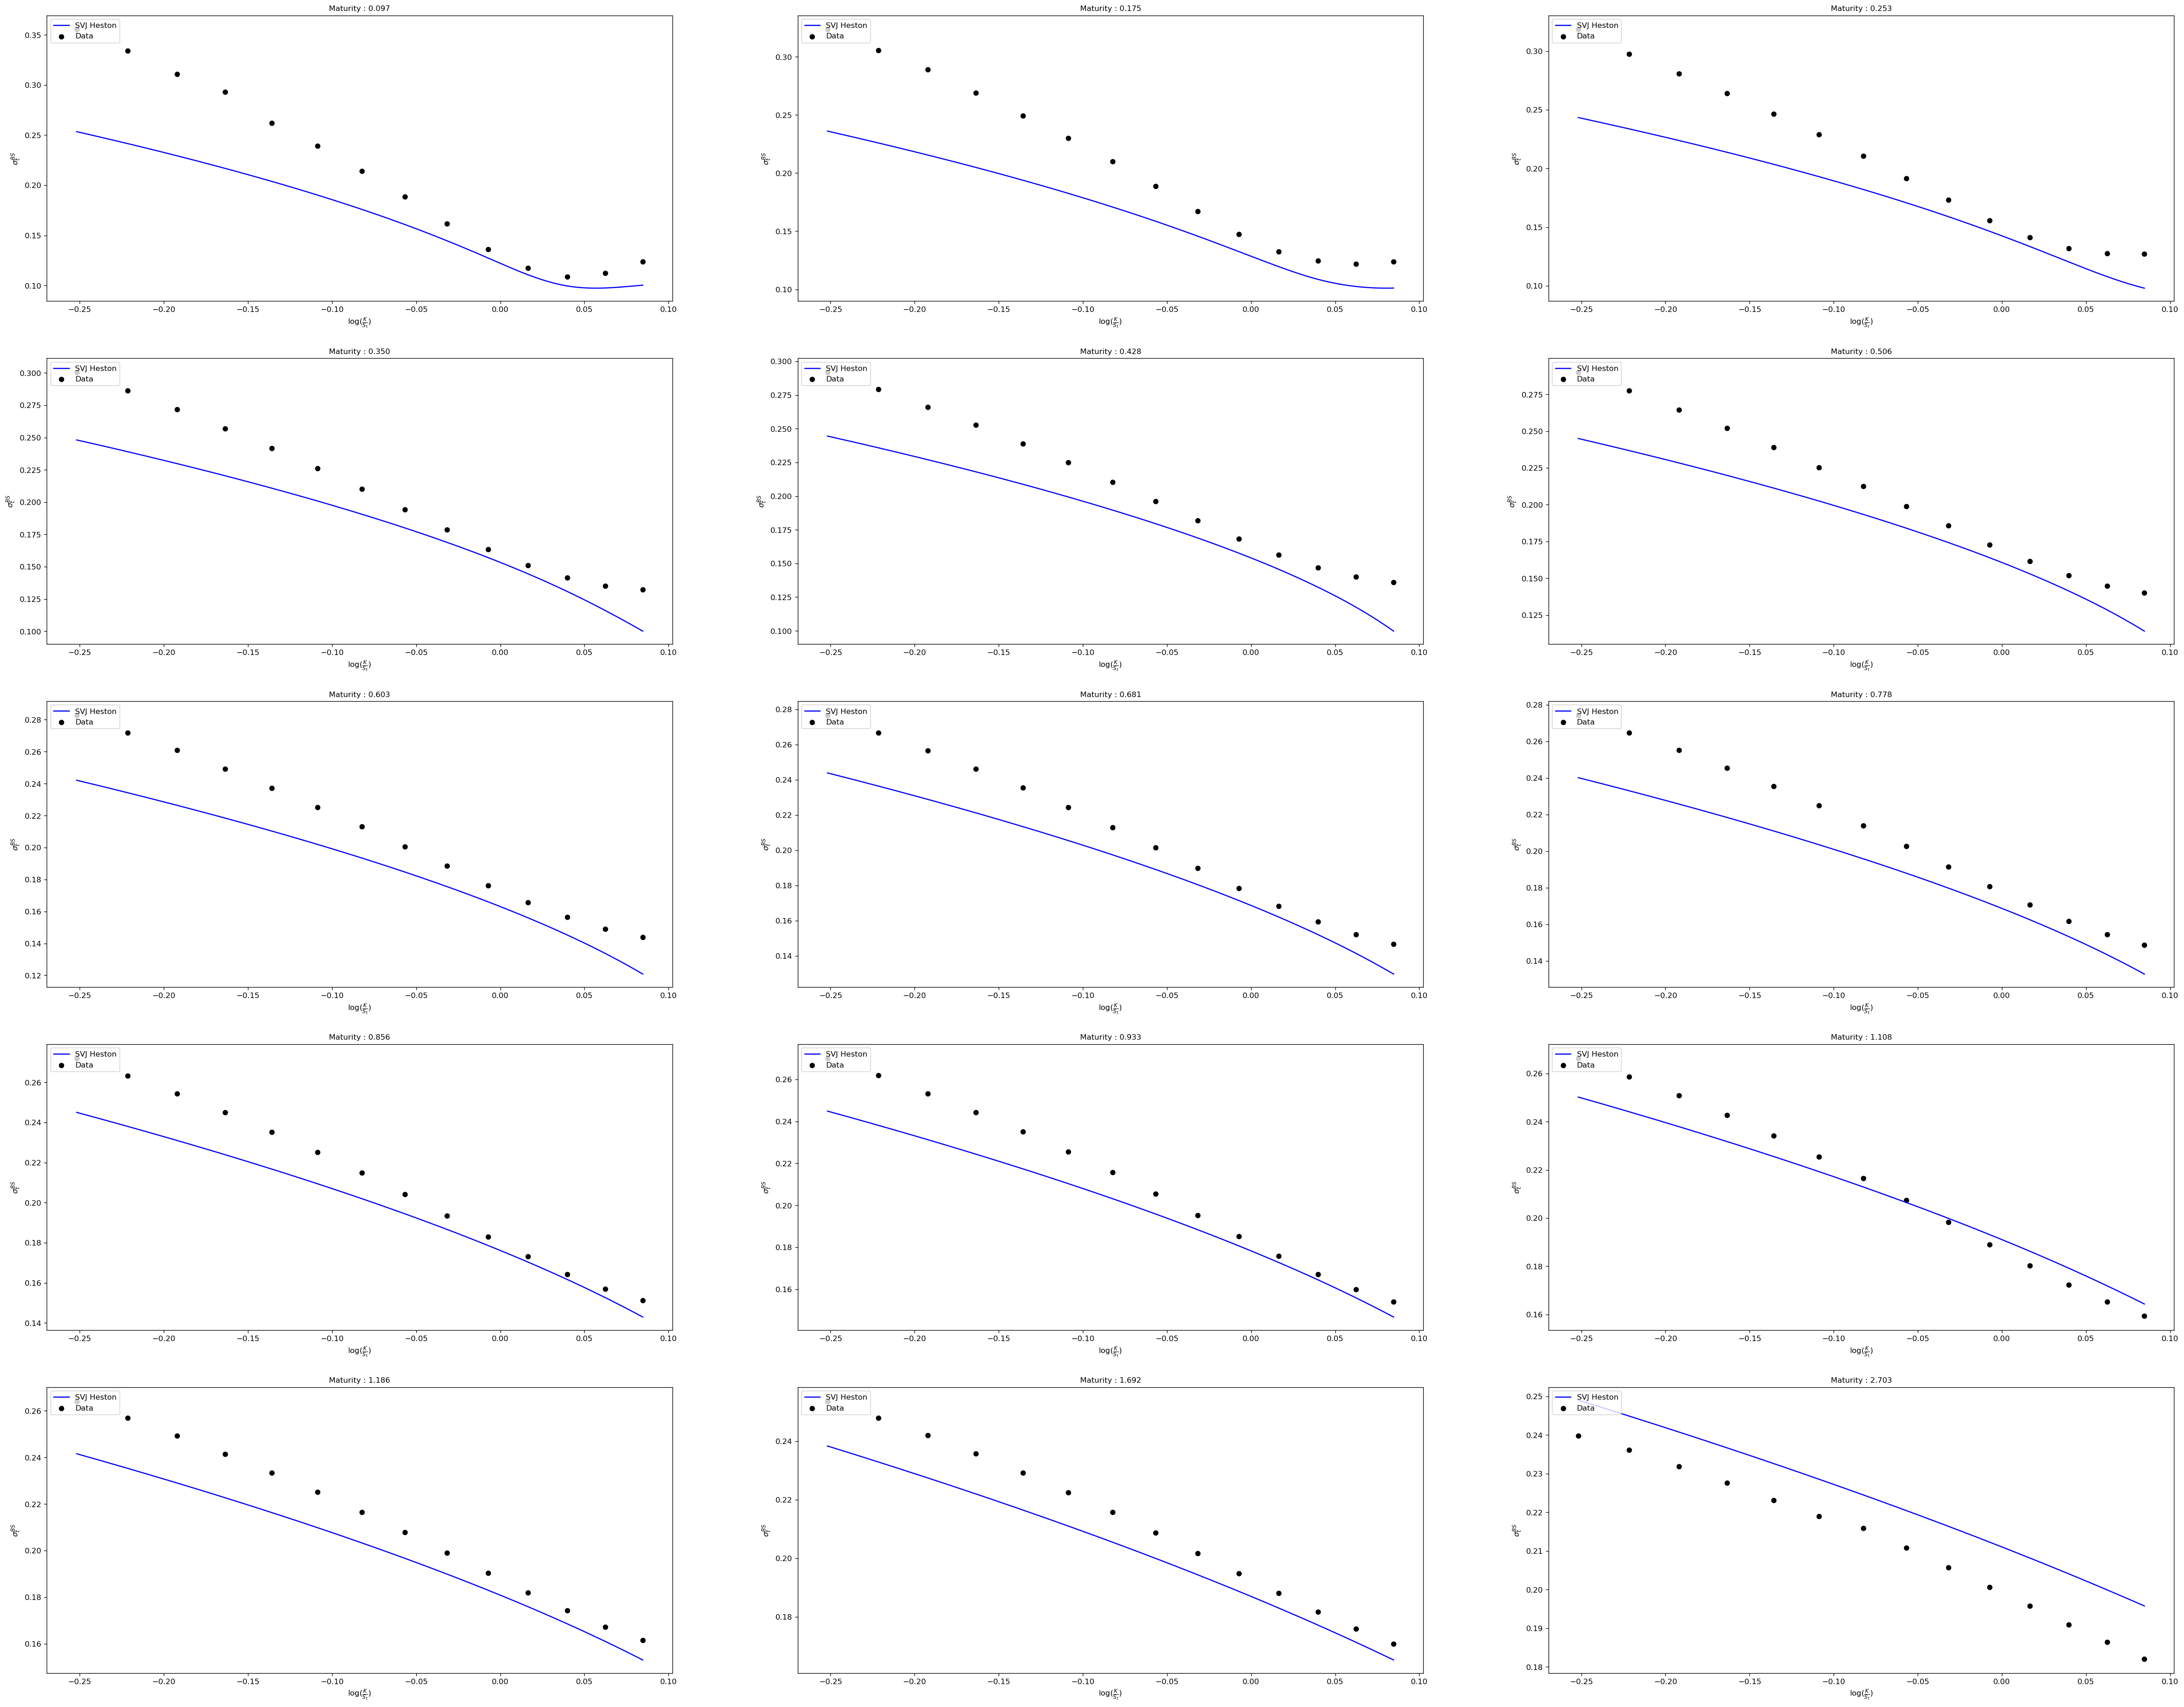

In [19]:
from scipy import interpolate
from scipy.interpolate import interp1d
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(50,40))
fig.canvas.set_window_title('Volatility Skews')
strikes = L.Strikes.sort_values().unique()
log_strikes = np.log(strikes/S0)
strks = np.linspace(strikes.min(),strikes.max(),300)
strks_log = np.log(strks/S0)
#r = 0.08/100
#q = 1.45/100
for i, ax in enumerate(axes.flatten()) :
    t,epdt = L.TTM.unique()[i],L.index.unique()[i]
    #s0 = S0*np.exp((r-q)*t)
    IV = Q.loc[t]['Implied Volatility'].values
    rho,sigma,theta,kappa,v0= rho_.get(epdt) , sigma_.get(epdt) , theta_.get(epdt), kappa_.get(epdt), v0_.get(epdt)
    price = np.array([call_price(kappa, theta, sigma, rho, v0 ,0 ,t ,S0 ,k,'No') for k in strikes])
    imp_vol1 = np.array([implied_volatility(price[i], S0, k, t, 0) for i,k in enumerate(strikes)])
    f = interp1d(strikes,imp_vol1,kind='cubic')
    imp_vol1 = f(strks) 
    ax.plot(strks_log,imp_vol1,color = 'blue',label = r'SVJ Heston')
    ax.scatter(log_strikes,IV,color = 'black',label = 'Data')
    ax.set_title('Maturity : %1.3f'%t,fontsize=10)
    ax.set_xlabel(r'$\log(\frac{K}{S_t})$')
    ax.set_ylabel(r'$\sigma_{t}^{BS}$')
    ax.legend(loc='upper left')
plt.show()

# Monofactorial SVM

In [20]:
theta_M, kappa_M, sigma_M, rho_M, v0_M = {},{},{},{},{}
strikes = L.Strikes.sort_values().unique().tolist()
date__ = L.TTM.sort_values().unique()
for j,i in enumerate(L.index.sort_values().unique()):
    date = ql.Date(i.day,i.month,i.year)
    t = date__[j]
    data = Q.loc[t]['Implied Volatility'].tolist()
    spreads = 1/Q.loc[t]['Spread']
    model4, engine4 = setup_model(yield_ts, dividend_ts, spot)
    heston_helpers4, grid_data4 = setup_helpersLC(engine4, date, strikes, data,calculation_date, spot, yield_ts, dividend_ts)
    initial_condition = (0.02, 0.2, 0.5, 0.1, 0.01)
    bounds = [(1e-5,10),(1e-5,100), (1e-5,10), (-1,-1), (1e-5,10)]
    bnds = ((1e-5,10),(1e-5,100), (1e-5,10), (-1,1), (1e-5,10))
    cost_function = cost_function_generator1(
    model4, heston_helpers4, norm=True)
    cost_function2 = cost_function_generator2(
    model4, heston_helpers4, norm=True,Mono = True)
    sol = differential_evolution(cost_function, bounds=bounds,tol =1e-9,maxiter = 100,popsize = 100,seed = 0)
    params_ = ql.Array(list(sol.x))
    model4.setParams(params_)
    sol = minimize(cost_function2,sol.x,tol =1e-9,method = 'Nelder-Mead')
    params_ = ql.Array(list(sol.x))
    model4.setParams(params_)
    theta_M[i], kappa_M[i], sigma_M[i], rho_M[i], v0_M[i] = model4.params()
    error = calibration_report(heston_helpers4, grid_data4)    
    summary.append(["Scipy DE1", error] + list(model4.params()))  

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


IVMSE  : 0.000668412
IVMSE  : 0.000357525
IVMSE  : 0.000273359
IVMSE  : 0.000189088
IVMSE  : 0.000154267
IVMSE  : 0.000122108
IVMSE  : 0.000129312
IVMSE  : 0.000123190
IVMSE  : 0.000130059
IVMSE  : 0.000132458
IVMSE  : 0.000116540
IVMSE  : 0.000166396
IVMSE  : 0.000078140
IVMSE  : 0.000042213
IVMSE  : 0.000017337


In [21]:
import datetime 
from datetime import date,timedelta
A3 = pd.DataFrame([theta_M.values(), kappa_M.values(), sigma_M.values(), rho_M.values(), v0_M.values()]\
                  ,columns = rho_M.keys(),index = ['Theta','Kappa','Sigma','Rho','V0'])
df_0 = pd.DataFrame()
for i in A.index :
    X,Y = x,A3.loc[i].values
    if i == 'Rho':
        df_0[i] = np.maximum(G_Interpolator(X,Y,x1).reshape(1,-1)[0],-1)
    else:
        df_0[i] = G_Interpolator(X,Y,x1).reshape(1,-1)[0]
    
df_0.index = np.array([date(2021, 4, 20) + timedelta(days = np.int(np.round(i * 360,2))) for i in x1])

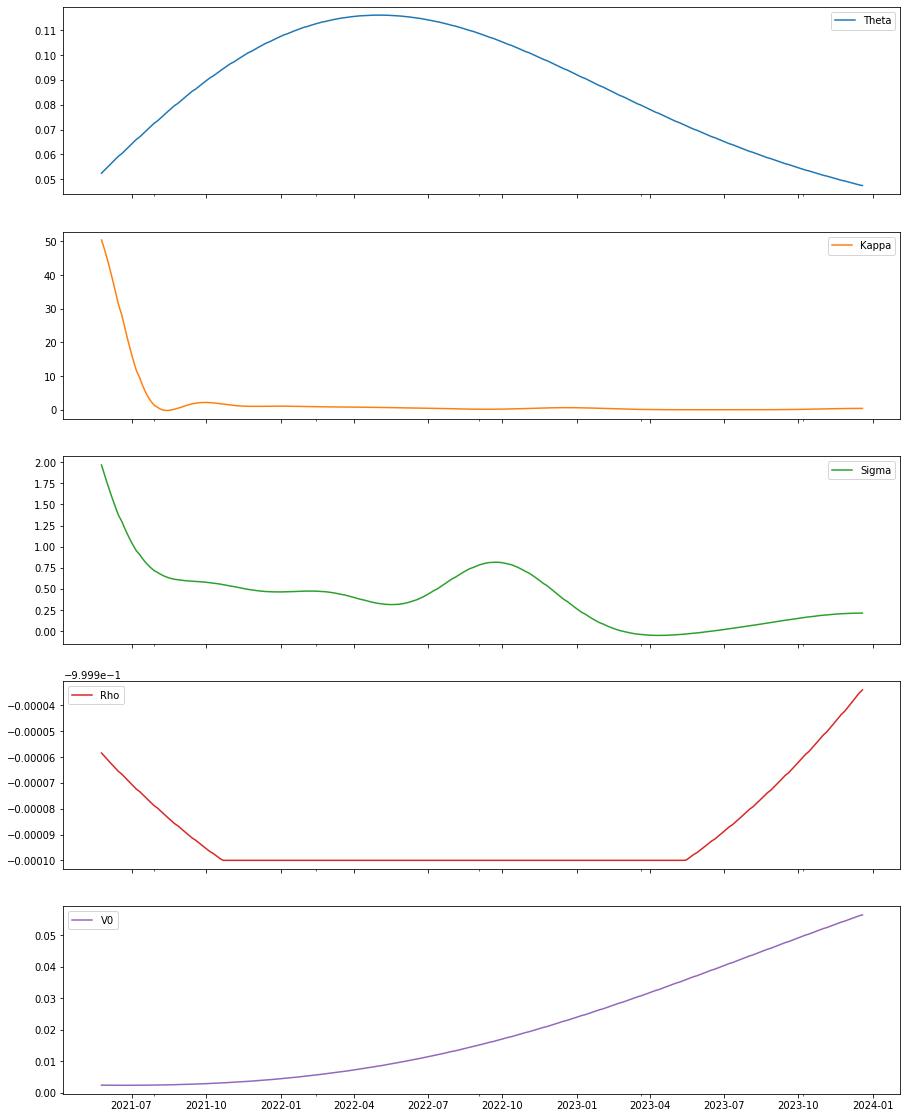

In [22]:
df_0.plot(subplots=True,figsize=(15,20))
plt.show()

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


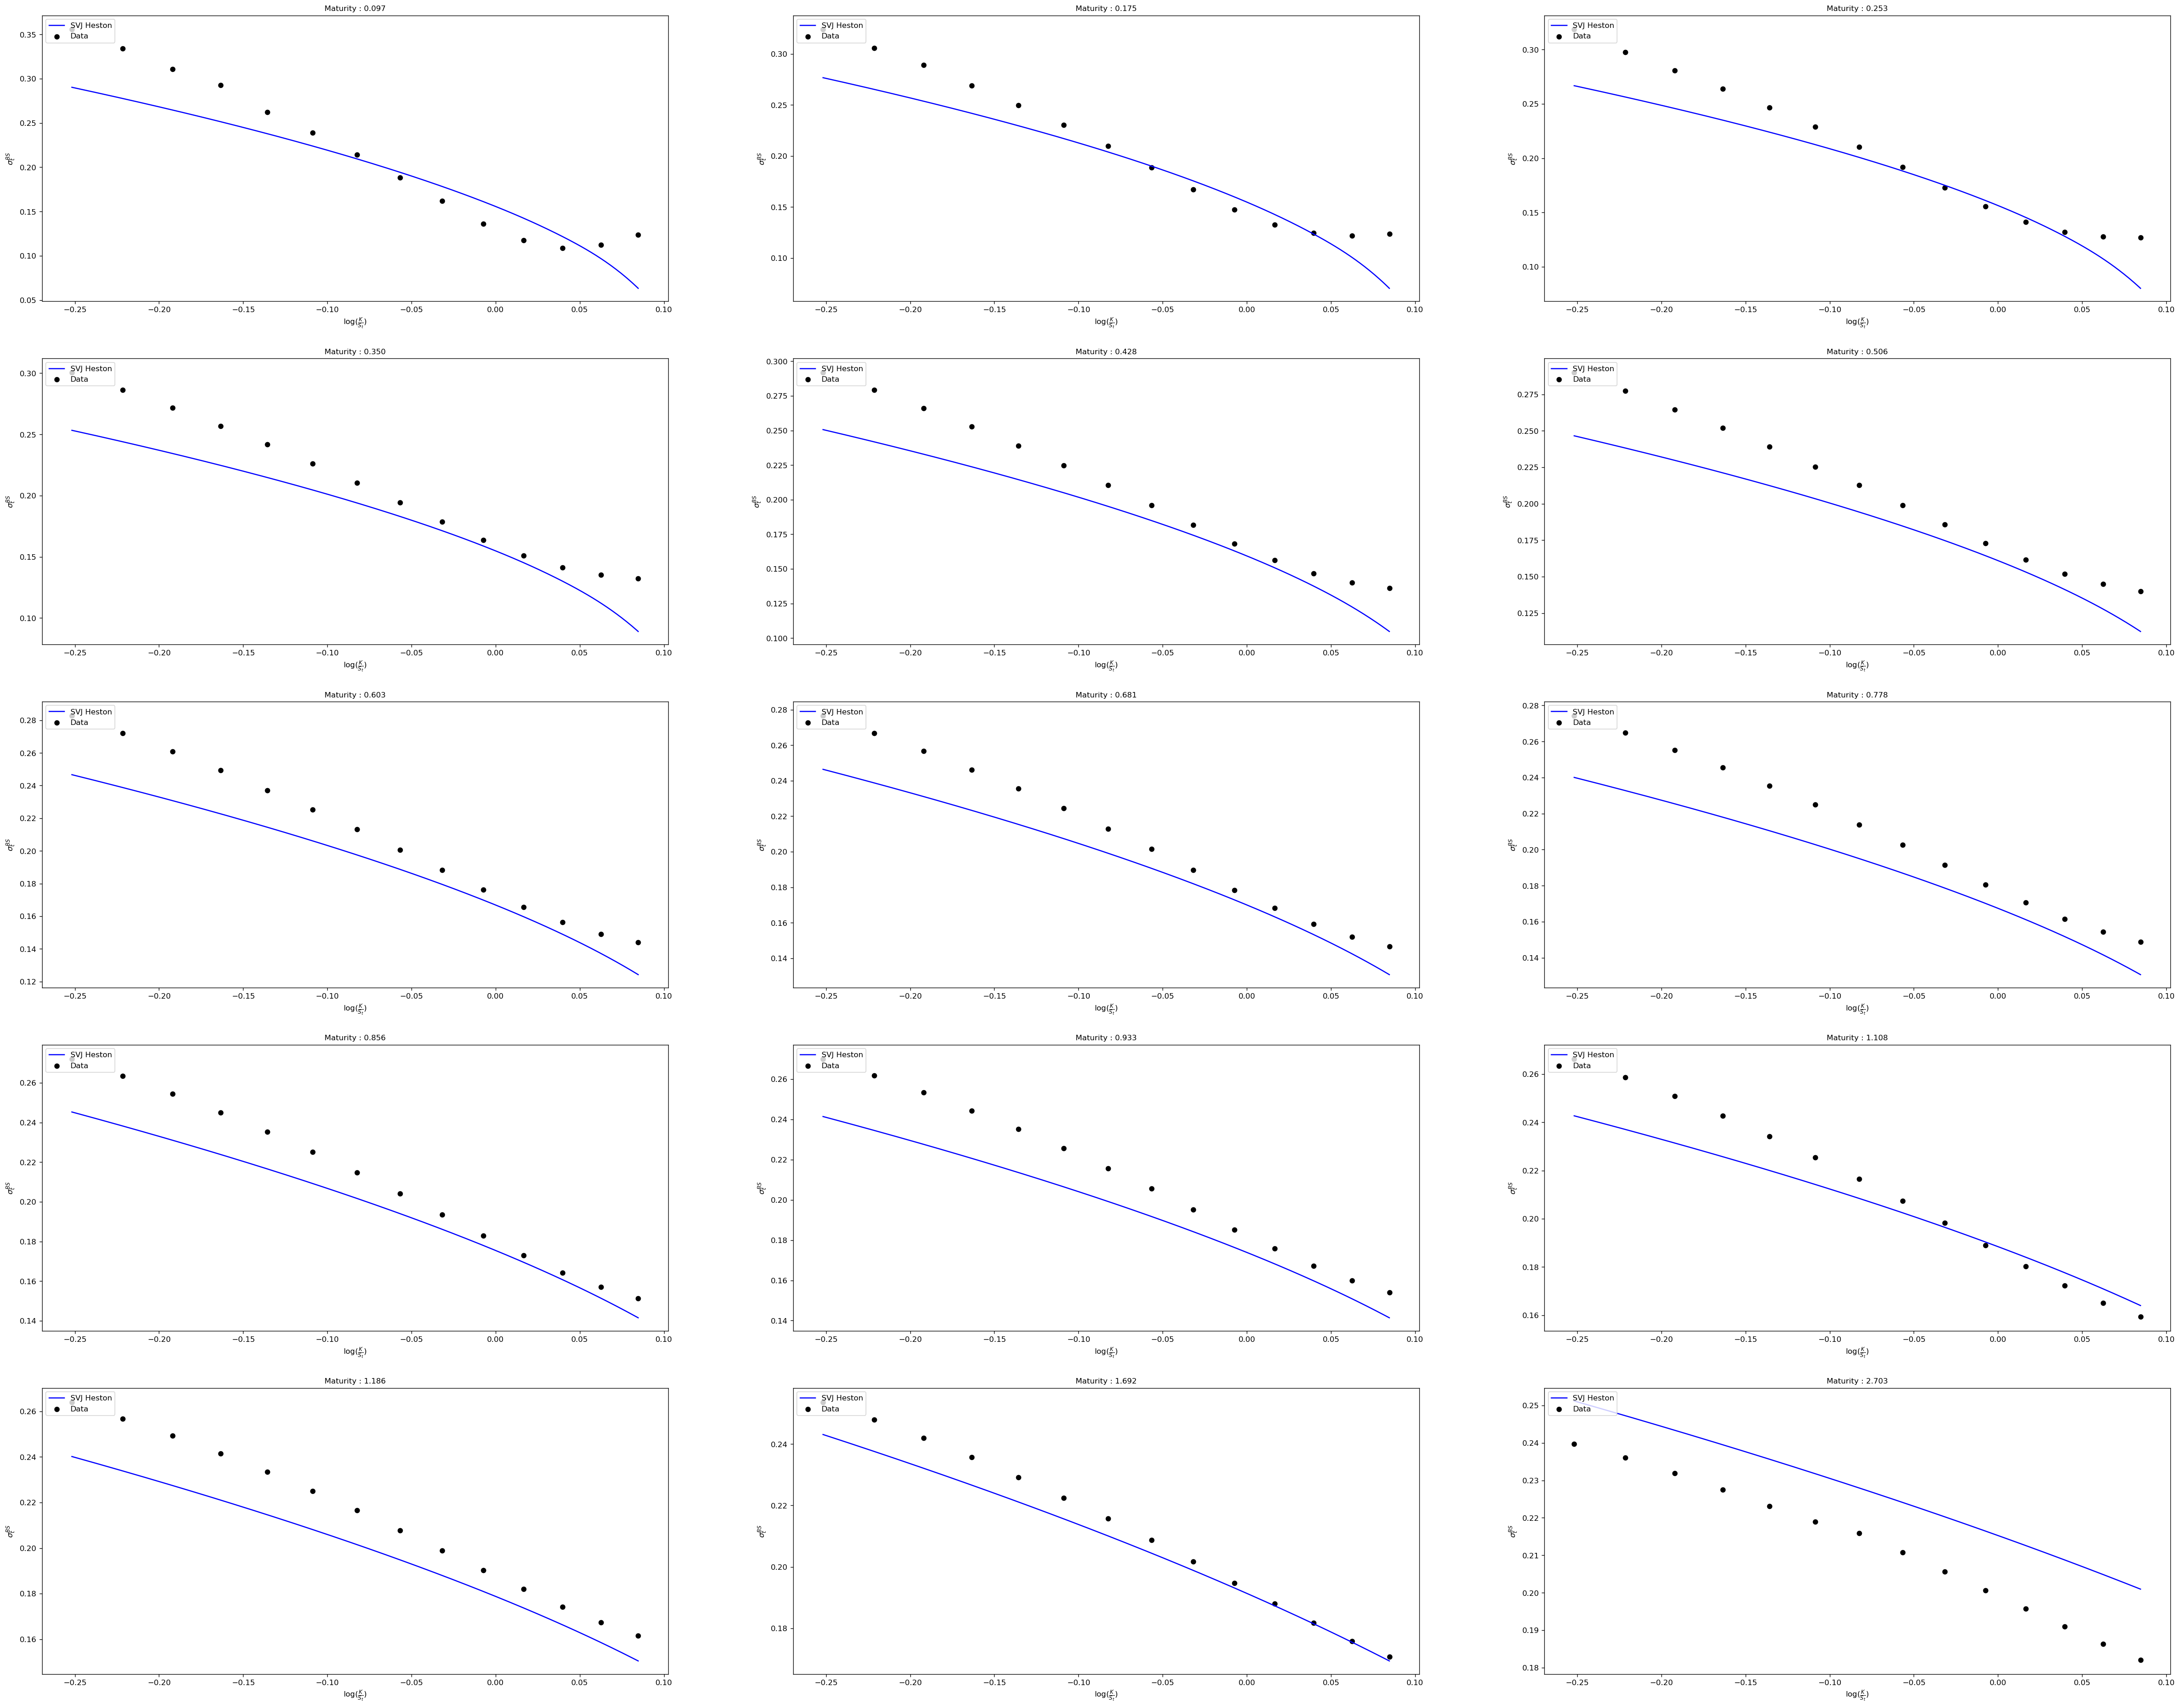

In [23]:
from scipy import interpolate
from scipy.interpolate import interp1d
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(50,40))
fig.canvas.set_window_title('Volatility Skews')
strikes = L.Strikes.sort_values().unique()
log_strikes = np.log(strikes/S0)
strks = np.linspace(strikes.min(),strikes.max(),300)
strks_log = np.log(strks/S0)
#r = 0.08/100
#q = 1.45/100
for i, ax in enumerate(axes.flatten()) :
    t,epdt = L.TTM.unique()[i],L.index.unique()[i]
    #s0 = S0*np.exp((r-q)*t)
    IV = Q.loc[t]['Implied Volatility'].values
    rho,sigma,theta,kappa,v0= rho_M.get(epdt) , sigma_M.get(epdt) , theta_M.get(epdt), kappa_M.get(epdt), v0_M.get(epdt)
    price = np.array([call_price(kappa, theta, sigma, rho, v0 ,0 ,t ,S0 ,k,'No') for k in strikes])
    imp_vol1 = np.array([implied_volatility(price[i], S0, k, t, 0) for i,k in enumerate(strikes)])
    f = interp1d(strikes,imp_vol1,kind='cubic')
    imp_vol1 = f(strks) 
    ax.plot(strks_log,imp_vol1,color = 'blue',label = r'SVJ Heston')
    ax.scatter(log_strikes,IV,color = 'black',label = 'Data')
    ax.set_title('Maturity : %1.3f'%t,fontsize=10)
    ax.set_xlabel(r'$\log(\frac{K}{S_t})$')
    ax.set_ylabel(r'$\sigma_{t}^{BS}$')
    ax.legend(loc='upper left')
plt.show()

# SVJ Jumps 

In [24]:
def setup_helpersLC(engine, date, strikes, 
                  data, ref_date, spot, yield_ts, 
                  dividend_ts):
    heston_helpers = []
    grid_data = []
    for j, s in enumerate(strikes):
            t = (date - ref_date )
            p = ql.Period(t, ql.Days)
            vols = data[j]
            helper = ql.HestonModelHelper(
                p, calendar, spot, s, 
                ql.QuoteHandle(ql.SimpleQuote(vols)),
                yield_ts, dividend_ts,ql.BlackCalibrationHelper.ImpliedVolError)
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
            grid_data.append((date, s))
    return heston_helpers, grid_data

def cost_function_generator1(model, helpers,norm=False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] -params[2]**2
        if pen_c < 1e-50:
            pen = 1e50
        #err =np.sum(spreads*(np.array([(opt.modelValue() - opt.marketValue())**2  for i, opt in enumerate(helpers)])))/np.sum(spreads)#[h.calibrationError() for h in helpers]r h in helpers]
        err =  pen * np.sum(spreads*np.abs([h.calibrationError() for h in helpers])**2)/np.sum(spreads)
        if norm:
            return pen * err #pen * np.sum(spreads *np.abs([h.calibrationError() for h in heston_helpers4])**2/np.array(data).reshape(1,195)[0])/np.sum(spreads)
        else:
            return error
    return cost_function


def cost_function_generator2(model, helpers,norm=False):
    def cost_function(params):
        pen = 1
        params_ = ql.Array(list(params))
        model.setParams(params_)
        pen_c = 2 * params[0] * params[1] - params[2]**2
        err = np.sum(spreads *np.abs([h.calibrationError() for h in helpers]))**2  * 1/np.sum(spreads)
        if pen_c < 1e-50 or params[0] < 1e-5 or params[1]<1e-5 or params[2]<1e-5 or params[4]<1e-5 or params[5]<1e-5 or params[7]<1e-5 or params[3]< -1 or params[5] > 0.10 :
            pen = 1e50
        if norm:
            return pen * err#len(heston_helpers4)
        else:
            return error
    return cost_function

def calibration_report(helpers, grid_data, detailed=False):
    IVMSE = np.sum(spreads* np.abs([h.calibrationError() for h in helpers])**2)/np.sum(spreads)
    if detailed: print("-"*100)
    summary = "IVMSE  : %1.9f" % (IVMSE)
    print(summary)
    return IVMSE
    
def setup_model(_yield_ts, _dividend_ts, _spot, 
                init_condition=(0.02,0.2,0.5,0.1,0.01,0.5,0.5,0.5)):
    theta, kappa, sigma, rho, v0,lambs,mu,sig_v = init_condition
    process = ql.BatesProcess (_yield_ts, _dividend_ts, 
                           ql.QuoteHandle(ql.SimpleQuote(_spot)), 
                           v0, kappa, theta, sigma, rho,lambs,mu,sig_v)
    model = ql.BatesModel(process)
    engine = ql.BatesEngine(model) 
    return model, engine

def Constraint(x):
    theta, kappa, sigma, rho, v0,lambda_,mu,sig_v = x
    A = 2*kappa*theta - sigma**2 
    return A

const = {'type': 'ineq', 'fun': Constraint}
summary= []

In [25]:
theta_1, kappa_1, sigma_1, rho_1, v0_1,lambda_,mu_,sigma_2v = {},{},{},{},{},{},{},{}
strikes = L.Strikes.sort_values().unique().tolist()
date__ = L.TTM.sort_values().unique()
for j,i in enumerate(L.index.sort_values().unique()):
    date = ql.Date(i.day,i.month,i.year)
    t = date__[j]
    data = Q.loc[t]['Implied Volatility'].tolist()
    spreads = 1/Q.loc[t]['Spread']
    model4, engine4 = setup_model(yield_ts, dividend_ts, spot)
    heston_helpers4, grid_data4 = setup_helpersLC(engine4, date, strikes, data,calculation_date, spot, yield_ts, dividend_ts)
    initial_condition = (0.02,0.2,0.5,0.1,0.01,0.5,0.5,0.5)
    bounds = [(1e-3,10),(1e-3,100), (1e-3,10), (-1,1), (1e-3,10),(1e-3,0.10),(-1,1),(1e-3,1)]
    bnds = ((1e-3,10),(1e-3,100), (1e-3,10), (-1,1), (1e-3,10),(1e-3,0.10),(-1,1),(1e-3,1))
    cost_function = cost_function_generator1(
    model4, heston_helpers4, norm=True)
    cost_function2 = cost_function_generator2(
    model4, heston_helpers4, norm=True)
    sol = differential_evolution(cost_function, bounds=bounds,tol =1e-9,maxiter = 50,popsize = 50,seed = 0)
    params_ = ql.Array(list(sol.x))
    model4.setParams(params_)
    sol = minimize(cost_function2,sol.x,tol =1e-9,method = 'Nelder-Mead')
    params_ = ql.Array(list(sol.x))
    model4.setParams(params_)
    theta_1[i], kappa_1[i], sigma_1[i], rho_1[i], v0_1[i],lambda_[i],mu_[i],sigma_2v[i] = model4.params()
    error = calibration_report(heston_helpers4, grid_data4)    
    summary.append(["Scipy DE1", error] + list(model4.params()))  

IVMSE  : 0.000393062
IVMSE  : 0.000404093
IVMSE  : 0.000471016
IVMSE  : 0.000334722
IVMSE  : 0.000563301
IVMSE  : 0.000303733
IVMSE  : 0.000437382
IVMSE  : 0.000371481
IVMSE  : 0.000342225
IVMSE  : 0.000222200
IVMSE  : 0.000376024
IVMSE  : 0.000210587
IVMSE  : 0.000206585
IVMSE  : 0.000174499
IVMSE  : 0.000064920


In [26]:
lambda_

{Timestamp('2021-05-21 00:00:00'): 0.005553599590473645,
 Timestamp('2021-06-18 00:00:00'): 0.04603336856126583,
 Timestamp('2021-07-16 00:00:00'): 0.06465928580390551,
 Timestamp('2021-08-20 00:00:00'): 0.0406918716799832,
 Timestamp('2021-09-17 00:00:00'): 0.04149556479011528,
 Timestamp('2021-10-15 00:00:00'): 0.03814059053784469,
 Timestamp('2021-11-19 00:00:00'): 1.0027249442392708e-05,
 Timestamp('2021-12-17 00:00:00'): 0.09270141165033566,
 Timestamp('2022-01-21 00:00:00'): 0.013484237467876279,
 Timestamp('2022-02-18 00:00:00'): 0.017892534298212817,
 Timestamp('2022-03-18 00:00:00'): 0.05208930332699371,
 Timestamp('2022-05-20 00:00:00'): 0.057455593563225896,
 Timestamp('2022-06-17 00:00:00'): 0.0008436919913317581,
 Timestamp('2022-12-16 00:00:00'): 0.04234064870856431,
 Timestamp('2023-12-15 00:00:00'): 0.012254979197108912}

In [27]:
A1 = pd.DataFrame([theta_1.values(), kappa_1.values(), sigma_1.values(), rho_1.values(), v0_.values(),\
                   lambda_.values(),mu_.values(),sigma_2v.values()],columns = rho_.keys(),\
                  index = ['Theta','Kappa','Sigma','Rho','V0','Lambda','Mu','sigma_v'])

In [29]:
import datetime 
from datetime import date,timedelta
df_1 = pd.DataFrame()
for i in A1.index :
    X,Y = x,A1.loc[i].values
    if i == 'Rho' or i == 'Mu':
        df_1[i] = np.maximum(G_Interpolator(X,Y,x1).reshape(1,-1)[0],-1)
    else:
        df_1[i] = np.maximum(G_Interpolator(X,Y,x1).reshape(1,-1)[0],1e-4)
    
df_1.index = np.array([date(2021, 4, 20) + timedelta(days = np.int(np.round(i * 360,2))) for i in x1])

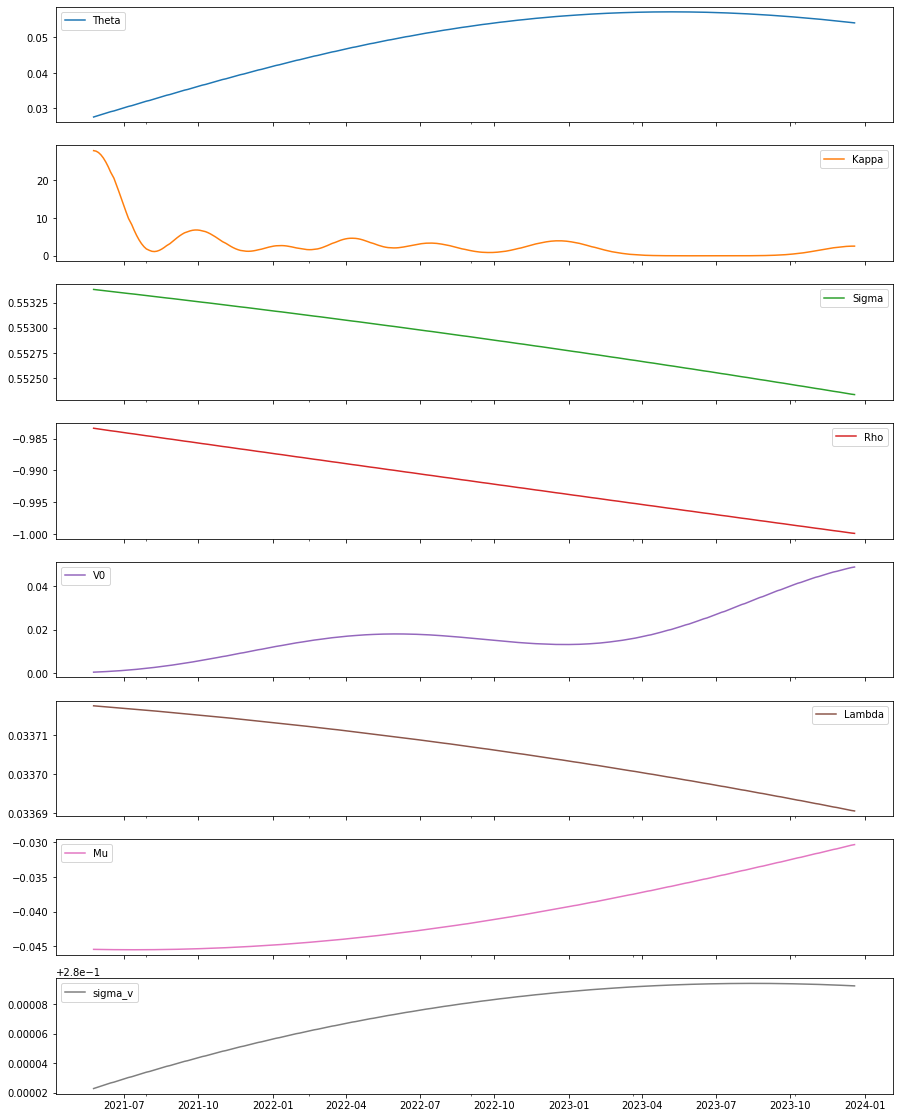

In [30]:
df_1.plot(subplots=True,figsize=(15,20))
plt.show()

/Users/elyes/opt/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


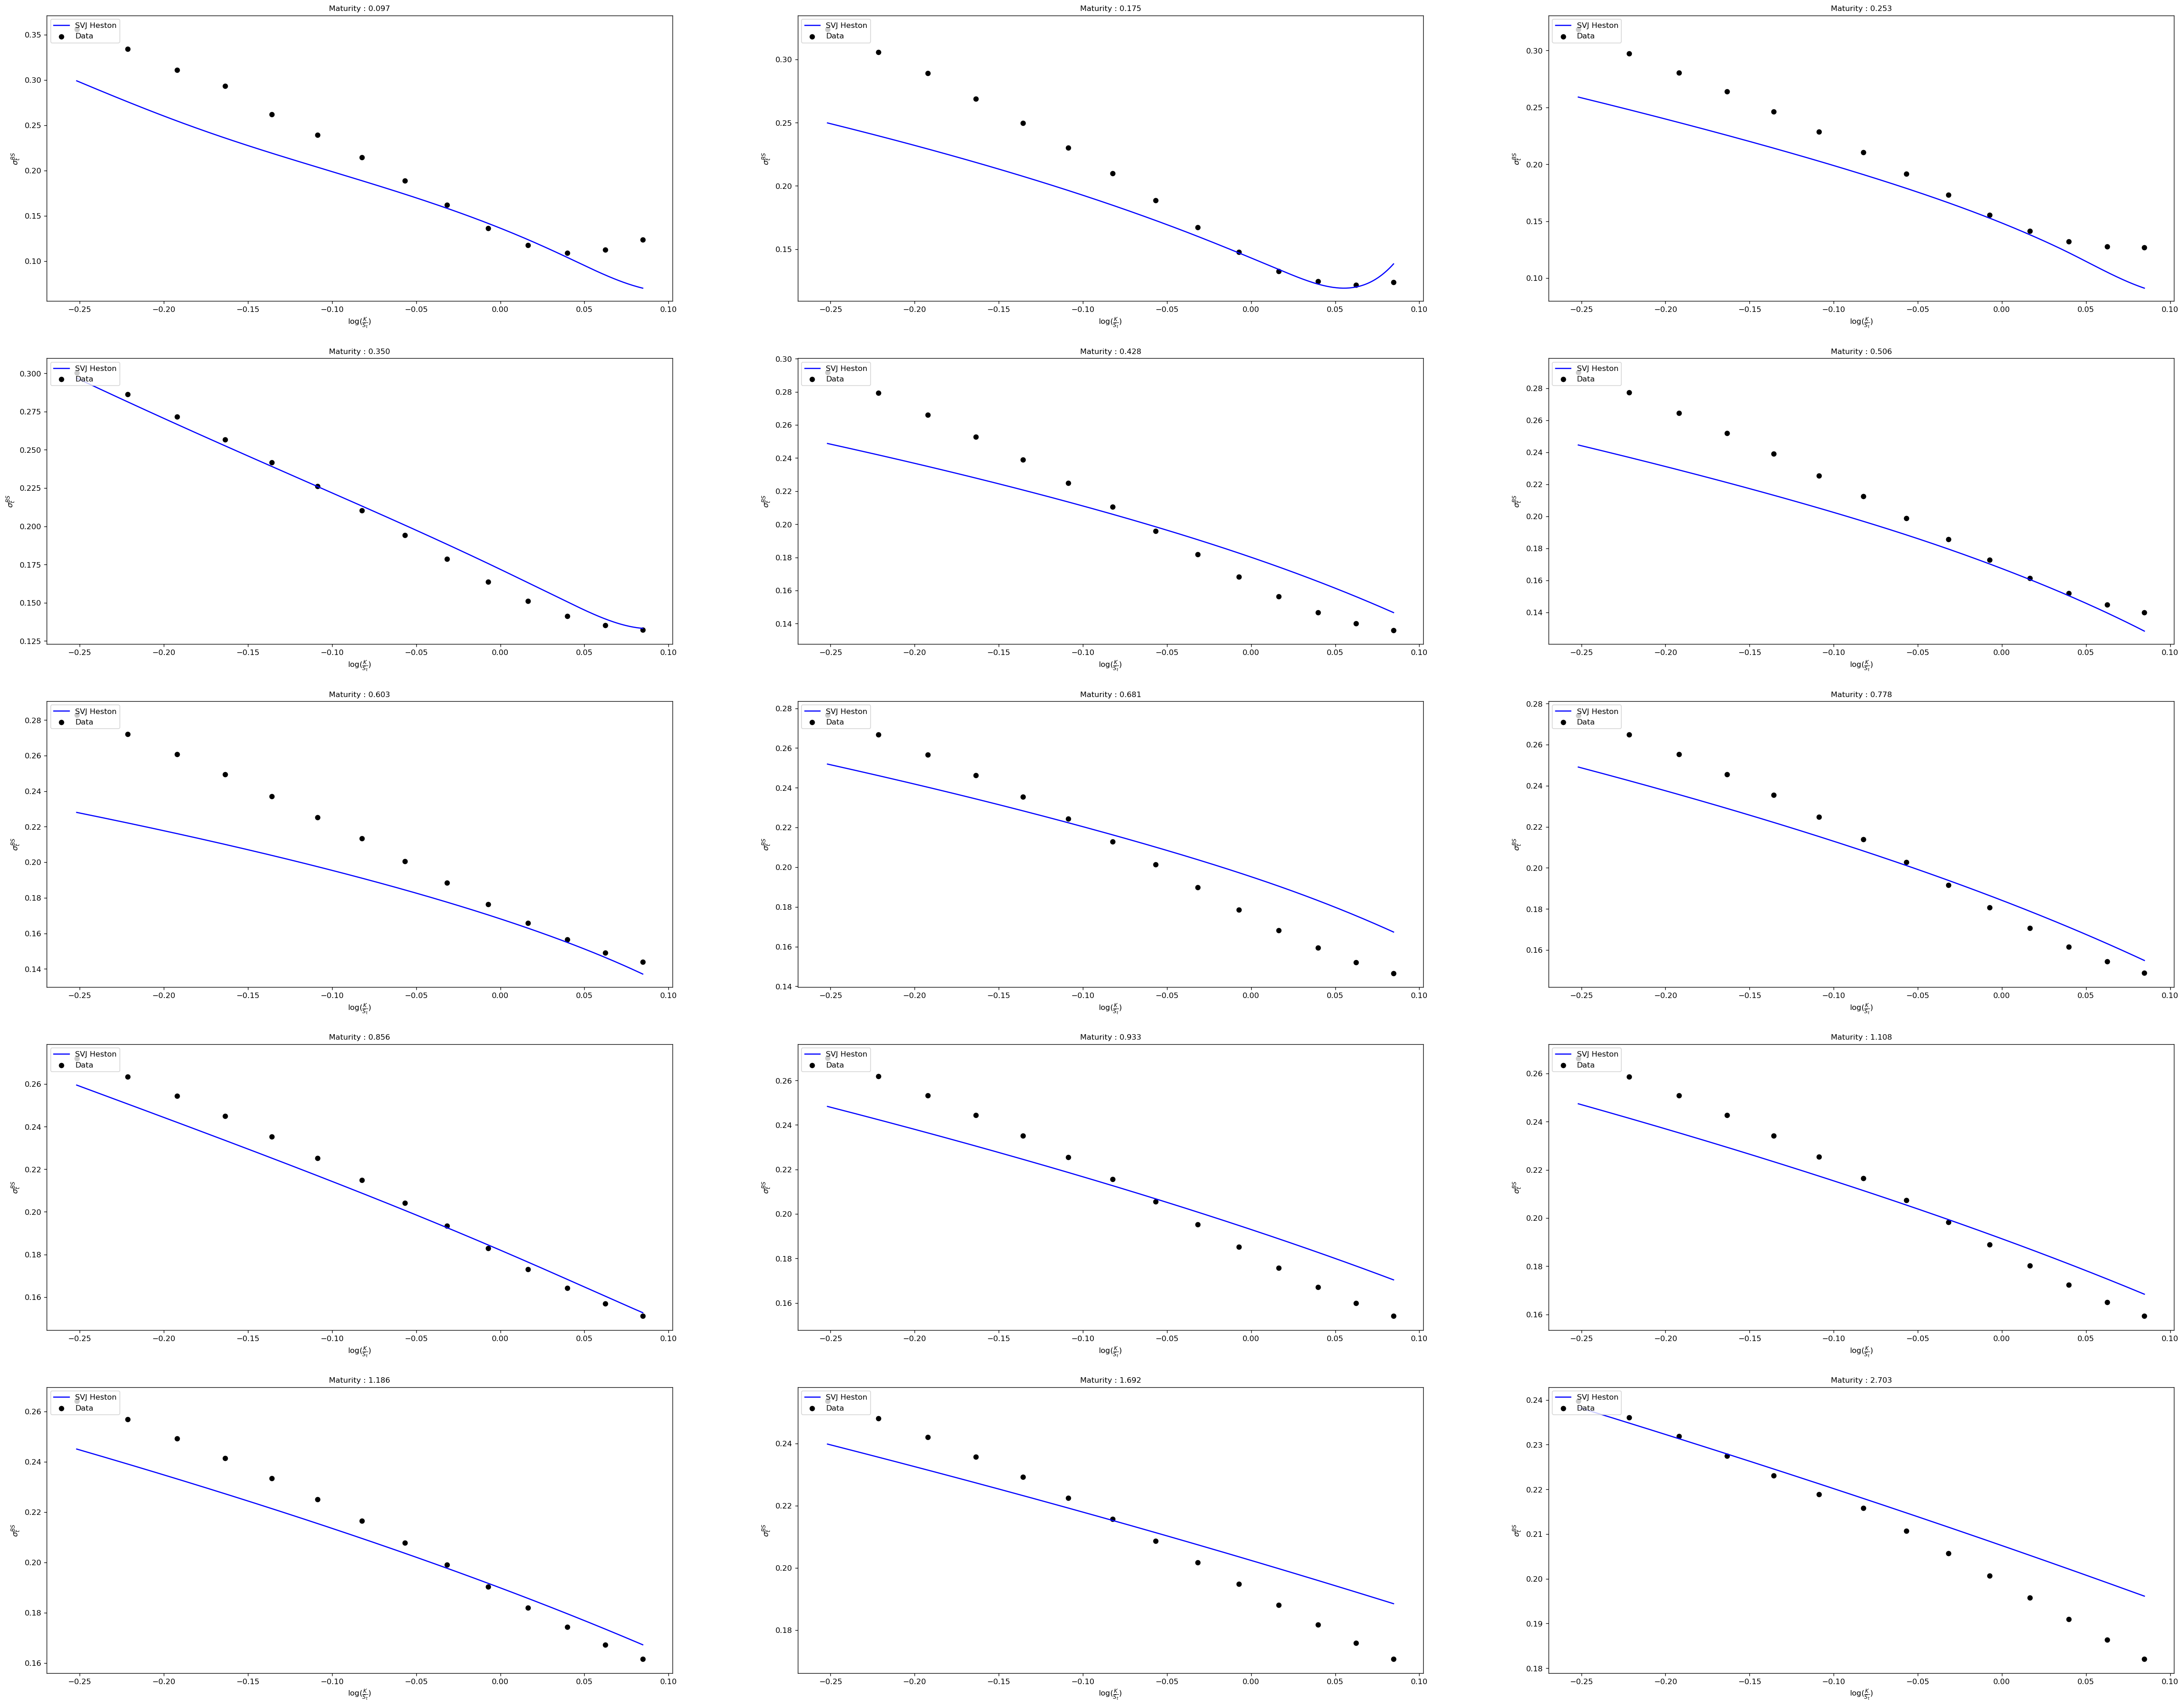

In [31]:
from scipy import interpolate
from scipy.interpolate import interp1d
fig, axes = plt.subplots(nrows=5, ncols=3, dpi=120, figsize=(50,40))
fig.canvas.set_window_title('Volatility Skews')
strikes = L.Strikes.sort_values().unique()
log_strikes = np.log(strikes/S0)
strks = np.linspace(strikes.min(),strikes.max(),300)
strks_log = np.log(strks/S0)
#r = 0.08/100
#q = 1.45/100
for i, ax in enumerate(axes.flatten()) :
    t,epdt = L.TTM.unique()[i],L.index.unique()[i]
    #s0 = S0*np.exp((r-q)*t)
    IV = Q.loc[t]['Implied Volatility'].values
    rho,sigma,theta,kappa,v0,lambd,mu,sig_v= rho_1.get(epdt) , sigma_1.get(epdt) , theta_1.get(epdt),\
    kappa_1.get(epdt), v0_1.get(epdt),lambda_.get(epdt),mu_.get(epdt),sigma_2v.get(epdt)
    price = np.array([call_price(kappa, theta, sigma, rho, v0 ,0 ,t ,S0 ,k,'No',lambd,mu,sig_v,0) for k in strikes])
    imp_vol1 = np.array([implied_volatility(price[i], S0, k, t, 0) for i,k in enumerate(strikes)])
    f = interp1d(strikes,imp_vol1,kind='cubic')
    imp_vol1 = f(strks) 
    ax.plot(strks_log,imp_vol1,color = 'blue',label = r'SVJ Heston')
    ax.scatter(log_strikes,IV,color = 'black',label = 'Data')
    ax.set_title('Maturity : %1.3f'%t,fontsize=10)
    ax.set_xlabel(r'$\log(\frac{K}{S_t})$')
    ax.set_ylabel(r'$\sigma_{t}^{BS}$')
    ax.legend(loc='upper left')
plt.show()

# Plot Every point

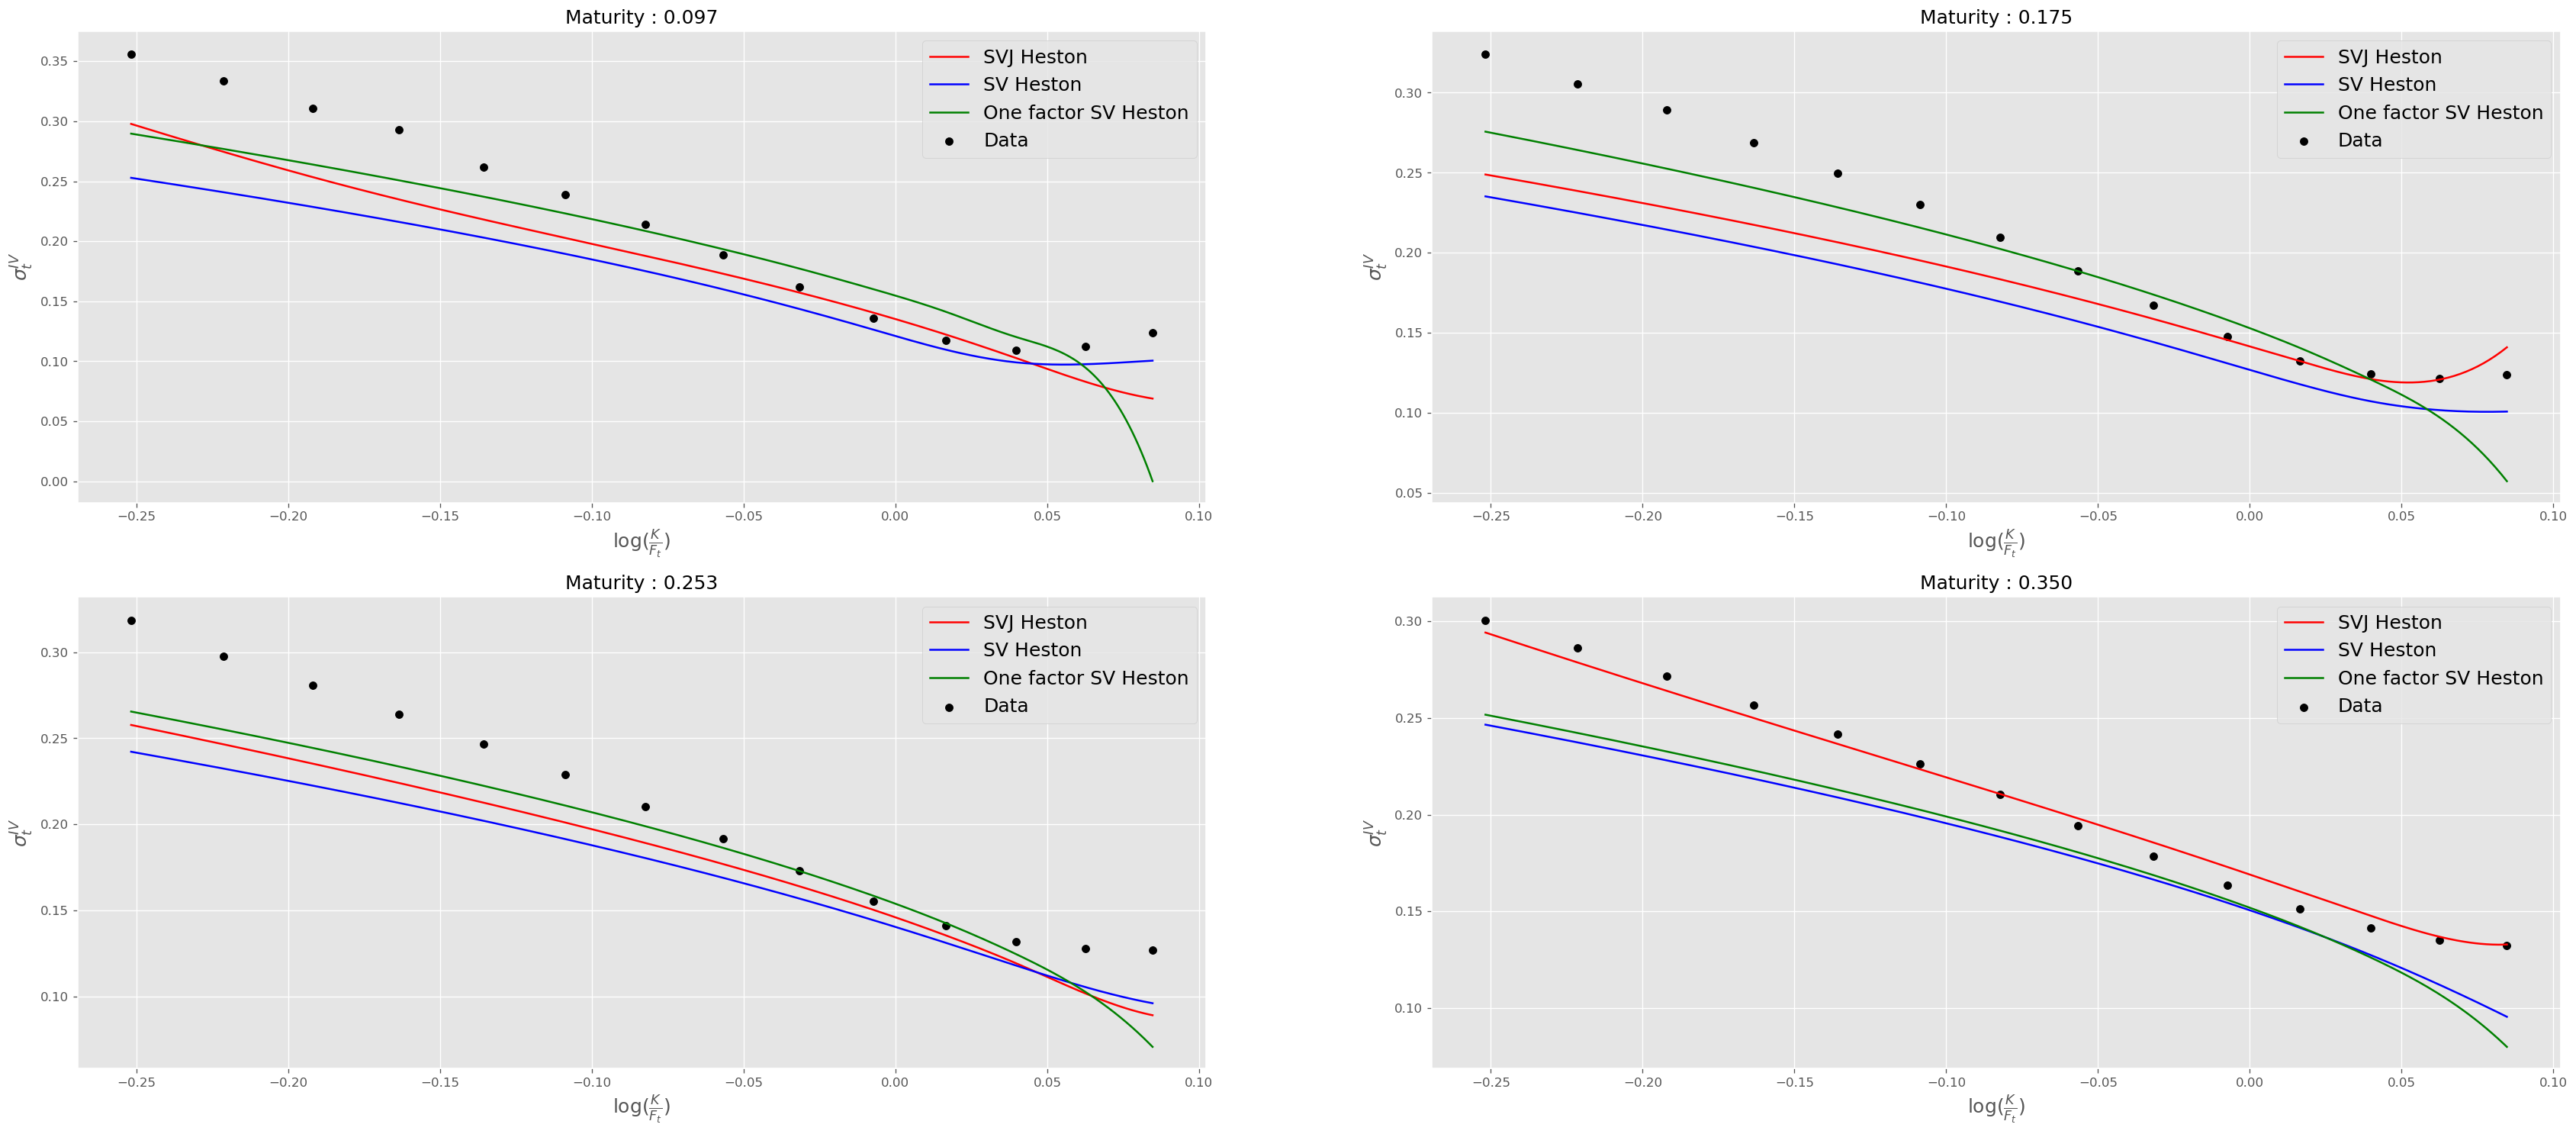

In [35]:
from scipy import interpolate
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import warnings; warnings.filterwarnings("ignore")
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(35,15))
fig.canvas.set_window_title('Volatility Skews')
strikes = L.Strikes.sort_values().unique()
log_strikes = np.log(strikes/S0)
strks = np.linspace(strikes.min(),strikes.max(),300)
strks_log = np.log(strks/S0)
#r = 0.08/100
#q = 1.45/100
for i, ax in enumerate(axes.flatten()) :
    if i >14:
        ax.plot()
        continue
    t,epdt = L.TTM.unique()[i],L.index.unique()[i]
    #s0 = S0*np.exp((r-q)*t)
    IV = Q.loc[t]['Implied Volatility'].values
    rho,sigma,theta,kappa,v0,lambd,mu,sig_v= rho_1.get(epdt) , sigma_1.get(epdt) , theta_1.get(epdt),\
    kappa_1.get(epdt), v0_1.get(epdt),lambda_.get(epdt),mu_.get(epdt),sigma_2v.get(epdt)
    price = np.array([call_price(kappa, theta, sigma, rho, v0 ,drift ,t ,S0 ,k,'No',lambd,mu,sig_v,0) for k in strikes])
    imp_vol1 = np.array([implied_volatility(price[i], S0, k, t, drift) for i,k in enumerate(strikes)])
    f = interp1d(strikes,imp_vol1,kind='cubic')
    imp_vol1 = f(strks) 
    rho,sigma,theta,kappa,v0= rho_M.get(epdt) , sigma_M.get(epdt) , theta_M.get(epdt), kappa_M.get(epdt), v0_M.get(epdt)
    price = np.array([call_price(kappa, theta, sigma, rho, v0 ,drift ,t ,S0 ,k,'No') for k in strikes])
    imp_vol2 = np.array([implied_volatility(price[i], S0, k, t, drift) for i,k in enumerate(strikes)])
    f = interp1d(strikes,imp_vol2,kind='cubic')
    imp_vol2 = f(strks) 
    rho,sigma,theta,kappa,v0= rho_.get(epdt) , sigma_.get(epdt) , theta_.get(epdt), kappa_.get(epdt), v0_.get(epdt)
    price = np.array([call_price(kappa, theta, sigma, rho, v0 ,drift ,t ,S0 ,k,'No') for k in strikes])
    imp_vol3 = np.array([implied_volatility(price[i], S0, k, t, drift) for i,k in enumerate(strikes)])
    f = interp1d(strikes,imp_vol3,kind='cubic')
    imp_vol3 = f(strks) 
    ax.plot(strks_log,imp_vol1,color = 'red',label = r'SVJ Heston')
    ax.plot(strks_log,imp_vol3,color = 'blue',label = r'SV Heston')
    ax.plot(strks_log,imp_vol2,color = 'green',label = r'One factor SV Heston')
    ax.scatter(log_strikes,IV,color = 'black',label = 'Data')
    ax.set_title('Maturity : %1.3f'%t,fontsize=15)
    ax.set_xlabel(r'$\log(\frac{K}{F_{t}})$',fontsize=15)
    ax.set_ylabel(r'$\sigma_{t}^{IV}$',fontsize=15)
    ax.legend(loc='upper right',fontsize=15)
plt.show()